<h1>  Classifying cats and dogs using pretrained Inception v3.</h1>

The main goal of Inception Network is to enhance the model discriminability for local patches with in the receptive field. micro neural network with more complex structures to abstract the data with in the receptive field. The feature maps are obtained by sliding the micro networks over the input in a similar manner as CNN. they are then fed to the next layer. Inception network is implemented by stacking multiple of the below described(fig-2) structure. by doing this we are able to utilize global average pooling over feature maps in the final classification layer.

<h2></h2> <img src =" https://cdn-images-1.medium.com/max/800/1*IN1lRBQQ8jW70J_nBAjxfw.png"> 


The authors noted that auxillary classifiers didn't contribute much untill near the end of training process, when accuracies were nearing saturation. they argued that they function as regularizes, especially If they have Batch norm or dropout operation.   

<h1>Inception module with dimension reduction.</h1>
<h2></h2> <img src ="https://cdn-images-1.medium.com/max/800/1*r7gzyKELi27bAo9sV_ZZzg.jpeg">

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
import torch
import torchvision
import cv2
from torchvision import models
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import PIL
import os,sys,time
%matplotlib inline

In [0]:
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [0]:
!ls

sample_data  train  train.zip  valid  valid.zip


In [0]:
train = "/content/train"
test = "/content/valid"

In [0]:
class Cat_Dog(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.img_lab={}
    for f in self.files:
      label = f.split('.')[0]
      self.img_lab[f] = label
    files = pd.Series(self.img_lab)
    self.labels,_ = files.factorize()
    self.transform = transform
  def __len__(self):
    return len(self.files)
  def __getitem__(self, idx):
    img = self.files[idx]
    label = self.labels[idx]
    image = PIL.Image.open(os.path.join(self.root_dir, img))
    if self.transform:
      image=self.transform(image)
    return image, label

In [0]:
train_data = Cat_Dog(train, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((299,299)), torchvision.transforms.ToTensor()]))
test_data = Cat_Dog(test, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((299,299)), torchvision.transforms.ToTensor()]))

In [0]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [0]:
img, label = next(iter(test_loader))


 1
 0
 1
 0
 0
 1
 0
 1
 0
 1
[torch.LongTensor of size 10]

torch.Size([3, 299, 299])


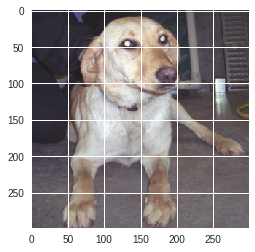

In [0]:
plt.imshow(img[0].permute(1,2,0))
print(label)
no_classes = 2
print(img[0].shape)

In [0]:
inception_v3 = models.inception_v3(pretrained=True)

In [0]:
print(inception_v3)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d (64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d (80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d (192, 64, kernel_si

In [0]:
# Freeze training for all layers
for param in inception_v3.parameters():
    param.require_grad = False

In [0]:
num_features=inception_v3.fc.in_features
print(num_features)
features = list(inception_v3.fc.children())[:-1]
features.extend([nn.Linear(num_features, no_classes)])
inception_v3.fc = nn.Sequential(*features)
print(inception_v3)

2048
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d (64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d (80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d (192, 64, kern

In [0]:
if use_gpu:
    inception_v3.cuda() #.cuda() will move everything to the GPU side

#loss function    
criterion = nn.CrossEntropyLoss()

#defining SGD optimizer with learning rate 0.001 and momentum 0.9
optimizer_ft = torch.optim.SGD(inception_v3.parameters(), lr=0.001, momentum=0.9)

In [0]:
#evaluating maodel before training

def eval_model(inception_v3, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_loader), end='', flush=True)

        
        inception_v3.train(False)
        inception_v3.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = inception_v3(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_loader)
    avg_acc = acc_test / len(test_loader)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [0]:
print("Test before training")
eval_model(inception_v3, criterion)


Test before training
Evaluating model
----------
Test batch 0/<torch.utils.data.dataloader.DataLoader object at 0x7f2e2386d908>
Evaluation completed in 0m 1s
Avg loss (test): 0.6805
Avg acc (test): 5.6667
----------


In [0]:
inputs, labels =next(iter(train_loader))
if use_gpu:
    inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
outputs = inception_v3(inputs)

In [0]:
torch.max(outputs.data, 1)

(
 -0.0076
 -0.0043
  0.0702
  0.0658
  0.1815
  0.0773
  0.2839
 -0.0960
  0.0210
  0.0666
 [torch.cuda.FloatTensor of size 10 (GPU 0)], 
  1
  0
  0
  1
  0
  1
  0
  0
  1
  1
 [torch.cuda.LongTensor of size 10 (GPU 0)])

In [0]:
def train_model(inception_v3, criterion, optimizer, num_epochs=50):
    since = time.time()
    best_model_wts = copy.deepcopy(inception_v3.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(test_loader)
 
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        #training the last layer
        inception_v3.train(True)
        
        for i, data in enumerate(train_loader):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            #if i >= train_batches / 2:
            #    break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            #print(type(inputs))
            #print(inputs.size())
            #print(type(inception_v3))
            outputs = inception_v3(inputs)
            #print(type(outputs))
            #print(type(outputs.data))
            
            _, preds = torch.max(outputs[0].data, 1)
            loss = criterion(outputs[0], labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / len(train_loader)
        avg_acc = acc_train * 2 / len(train_loader)
        
        inception_v3.train(False)
        inception_v3.eval()
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
            
        for i, data in enumerate(test_loader):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = inception_v3(inputs)
           
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(test_loader)
        avg_acc_val = acc_val / len(test_loader)
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(inception_v3.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    inception_v3.load_state_dict(best_model_wts)
    return inception_v3

In [0]:
inception_v3 = train_model(inception_v3, criterion, optimizer_ft, num_epochs=50)

Epoch 0/50
----------
Training batch 0/2.5
Avg loss (train): 0.3705
Avg acc (train): 19.6000
Validation batch 0/3
Epoch 0 result: 
Avg loss (train): 0.3705
Avg acc (train): 19.6000
Avg loss (val): 0.8877
Avg acc (val): 2.6667
----------

Epoch 1/50
----------
Training batch 0/2.5
Avg loss (train): 0.2337
Avg acc (train): 20.0000
Validation batch 0/3
Epoch 1 result: 
Avg loss (train): 0.2337
Avg acc (train): 20.0000
Avg loss (val): 1.0201
Avg acc (val): 2.0000
----------

Epoch 2/50
----------
Training batch 0/2.5
Avg loss (train): 0.3498
Avg acc (train): 19.6000
Validation batch 0/3
Epoch 2 result: 
Avg loss (train): 0.3498
Avg acc (train): 19.6000
Avg loss (val): 1.1073
Avg acc (val): 2.6667
----------

Epoch 3/50
----------
Training batch 0/2.5
Avg loss (train): 0.2282
Avg acc (train): 19.6000
Validation batch 0/3
Epoch 3 result: 
Avg loss (train): 0.2282
Avg acc (train): 19.6000
Avg loss (val): 0.9541
Avg acc (val): 2.6667
----------

Epoch 4/50
----------
Training batch 0/2.5
Avg l

In [0]:
inception_v3(inputs)[0]

Variable containing:
-0.8499
 0.5349
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



In [0]:
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[classes[x] for x in classes])

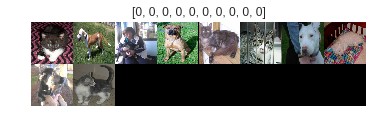

In [0]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
show_databatch(inputs, classes)